# Configuration

In [14]:
#%matplotlib notebook
%matplotlib inline

import sklearn.cluster as skcl;
import pandas as pd;

import matplotlib.pyplot as plt

import feature_normalization as fn

from bisect import bisect
import seaborn as sns
import numpy as np


## Read Data

In [15]:
features = pd.read_csv( filepath_or_buffer="features.txt" , sep="\t" )
features = features.query( 'longest_stop_s >= 0' )
print( features.head( 3 ) );

      agentId  longest_stop_s  longest_stop_9_16_s  longest_trip_m  \
0  1000000700         42572.0               7906.0    85823.402291   
2  1000001200         46706.0                 -1.0    29981.333807   
3  1000002000         72688.0                 -1.0    64868.908859   

   total_stop_s   total_trip_m  
0       71995.0  260486.880229  
2       82621.0   59067.391061  
3       80616.0  111247.858032  


## Plot data

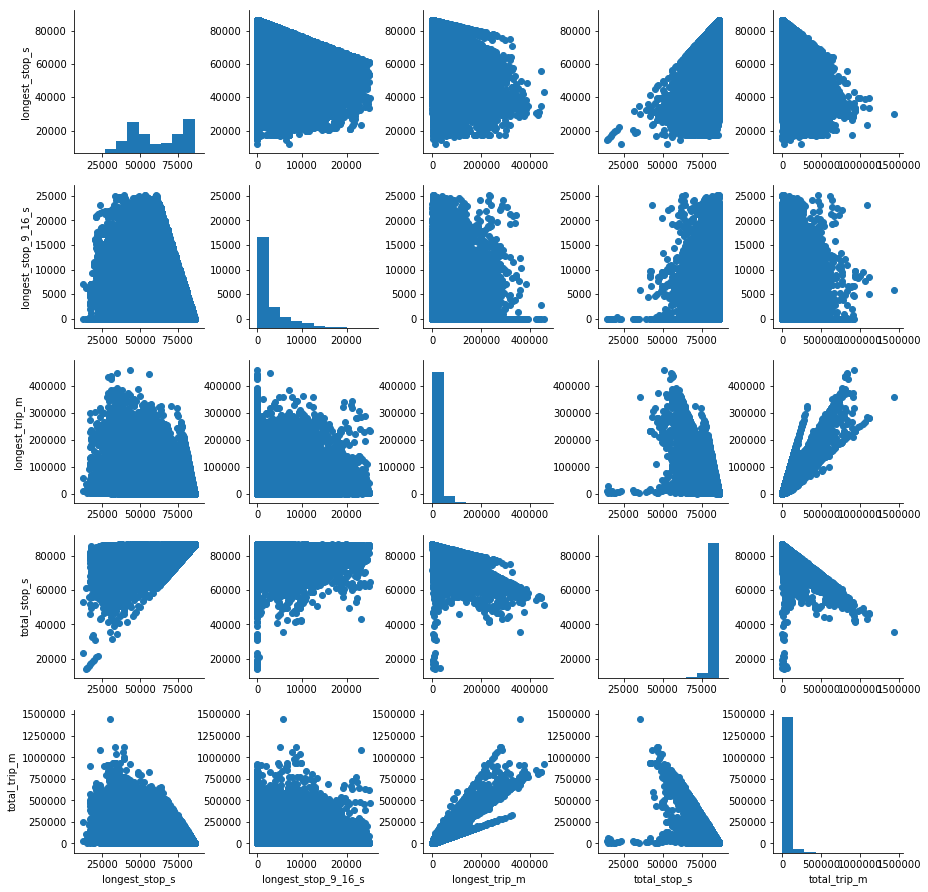

In [16]:
feature_names = features.columns.values

# start at 1 because 0 is agent id
#for i in range(1, len( feature_names ) ):
#    #print( "index i=" , i )
#    for j in range( i + 1 , len( feature_names ) ):
#        #print( "index j=" , j )
#        feature1 = feature_names[ i ]
#        feature2 = feature_names[ j ]
#        plt.scatter( features[ feature1 ] , features[ feature2 ] )
#        plt.xlabel( feature1 )
#        plt.ylabel( feature2 )
#        plt.show()
        
grid = sns.PairGrid( features , vars=feature_names[1:] )
grid.map_diag( plt.hist )
grid.map_offdiag( plt.scatter )


## Normalize features


In [17]:
norm_features = fn.normalize_features( features )

print( norm_features.head() )


      agentId  longest_stop_s  longest_stop_9_16_s  longest_trip_m  \
0  1000000700       -0.000004         5.030146e-06        0.000014   
2  1000001200       -0.000003        -2.542042e-06        0.000003   
3  1000002000        0.000002        -2.542042e-06        0.000010   
5  1000002500        0.000004         1.432263e-07       -0.000002   
6  1000004400        0.000005        -2.542042e-06        0.000001   

   total_stop_s  total_trip_m  
0     -0.000020      0.000021  
2     -0.000002      0.000002  
3     -0.000006      0.000007  
5      0.000002     -0.000002  
6      0.000002     -0.000001  


## Train clustering algorithm

### K Means

In [18]:
kmeans_per_size = {}

for n_clusters in range(2,11):
    kmeans = skcl.KMeans(n_clusters=n_clusters)
    kmeans.fit(norm_features)
    kmeans_per_size[ n_clusters ] = kmeans

n_cluster_list = list( kmeans_per_size.keys() )
score = list( map( lambda k: k.score( norm_features ), kmeans_per_size.values() ) )
plt.plot( n_cluster_list , score )

KeyboardInterrupt: 

In [ ]:
# from looking at score, 5 seems to be a good choice ("elbow")
pred = kmeans_per_size[ 5 ].predict( norm_features )
# start at 1 because 0 is agent id
#for i in range(1, len( feature_names ) ):
#    #print( "index i=" , i )
#    for j in range( i + 1 , len( feature_names ) ):
#        #print( "index j=" , j )
#        feature1 = feature_names[ i ]
#        feature2 = feature_names[ j ]
#        plt.scatter( features[ feature1 ] , features[ feature2 ] , c=pred , alpha=.5 )
#        plt.xlabel( feature1 )
#        plt.ylabel( feature2 )
#        plt.show()

for i in range(5):
    print( "cluster " , i )
    f = features[ pred == i ]
    print( "number of elements: " , len( f.index ) )
    print( f.describe().transpose() )
    grid = sns.PairGrid( f , vars=feature_names[1:] )
    grid.map_diag( plt.hist )
    grid.map_upper( plt.scatter )
    #grid.map_lower( sns.kdeplot , cmap="Blues_d" )


## Meaningful clustering

Clustering based on meaningful boundaries.

First define some charging times. From https://www.clippercreek.com/wp-content/uploads/2016/04/TIME-TO-CHARGE-20170706_FINAL-LOW-RES.jpg, full charging times range from 2 to 70 hours depending on vehicle and charging station.

In [19]:
charge_time_thresholds = np.array( [ 3600 * 2 ** i for i in range(1,10) if (2 ** i <= 24) ] )
print( charge_time_thresholds )

Then define range.
- Range of nissan leaf (most common EV): 135km https://en.wikipedia.org/wiki/Nissan_Leaf
- Tesla 85D: 270 miles = 434km https://www.tesla.com/fr_CH/blog/driving-range-model-s-family?redirect=no

Range depends on lots of factors, so we just use a few thresholds starting at 50km up to 400km

In [20]:
range_thresholds = np.array( [ 50 * 1000 * 2 ** i for i in range(4) ] )
print( range_thresholds / 1000 )

[  50.  100.  200.  400.]


Now, just generate one label per combination and compute labels

In [29]:
def find_threshold( t , thresholds , unit ):
    if t == len( thresholds ):
        return ''.join( ( "> " , str( thresholds[ t - 1 ] ) , unit ) )
    if t == 0:
        return ''.join( ( "[0 , " , str( thresholds[ t ] ) , unit , "]" ) )
    return ''.join( ( "[" , str( thresholds[ t - 1 ] ) , " , " , str( thresholds[ t ] ) , unit , "]" ) )

def comp_label( range_classes , charge_time_classes ):
    m = map( lambda r , t: "".join(
                ( "range_" , find_threshold( r ,  range_thresholds / 1000 , "km" ) ,
                  "-time_" , find_threshold( t , charge_time_thresholds / 3600 , "h" ) ) ) ,
             range_classes , charge_time_classes ) 
    return np.array( list( m ) ) 

pred_meaning = (features.assign( range_class = list( map( lambda x: bisect( range_thresholds , x ) , features.total_trip_m ) ),
                  charge_time_class = list( map( lambda x: bisect( charge_time_thresholds , x ) , features.longest_stop_9_16_s )))
        .assign( range_label = lambda x: list( map( lambda t: find_threshold( t , range_thresholds / 1000 , "km" ) , x.range_class ) ),
                 charge_time_label = lambda x: list( map( lambda t: find_threshold( t , charge_time_thresholds / 3600 , "h" ) , x.charge_time_class ) ) )
        .assign( label = lambda x: comp_label( x.range_class , x.charge_time_class)))


In [30]:
# start at 1 because 0 is agent id
#for i in range(1, len( feature_names ) ):
#    #print( "index i=" , i )
#    for j in range( i + 1 , len( feature_names ) ):
#        #print( "index j=" , j )
#        feature1 = feature_names[ i ]
#        feature2 = feature_names[ j ]
#        plt.scatter( features[ feature1 ] , features[ feature2 ] , c=pred_meaning.label  )
#        plt.xlabel( feature1 )
#        plt.ylabel( feature2 )
#        plt.show()
feature_names = features.columns.values

grid = sns.PairGrid( pred_meaning.assign( longest_stop_h = pred_meaning.longest_stop_s / 3600,
                                          longest_stop_9_16_h = pred_meaning.longest_stop_9_16_s / 3600,
                                          longest_trip_km = pred_meaning.longest_trip_m / 1000,
                                          total_stop_h = pred_meaning.total_stop_s / 3600,
                                          total_trip_km = pred_meaning.total_trip_m / 1000)
                             , vars=["longest_stop_h","longest_stop_9_16_h","longest_trip_km","total_stop_h","total_trip_km"] , hue='label' )
grid.map_diag( plt.hist )
grid.map_upper( plt.scatter , alpha=.5 )
grid.add_legend()
plt.savefig( 'meaningful_clusters.png' )

In [31]:
print( pd.crosstab( pred_meaning.range_label , pred_meaning.charge_time_label ) )

charge_time_label  [0 , 2.0h]  [2.0 , 4.0h]  [4.0 , 8.0h]
range_label                                              
> 400.0km                 995           224            58
[0 , 50.0km]           226840         22939          6032
[100.0 , 200.0km]       15503          3086           722
[200.0 , 400.0km]        3864           743           200
[50.0 , 100.0km]        44174          7476          1866
